In [77]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\left\\ba676390_nohash_1.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [7]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

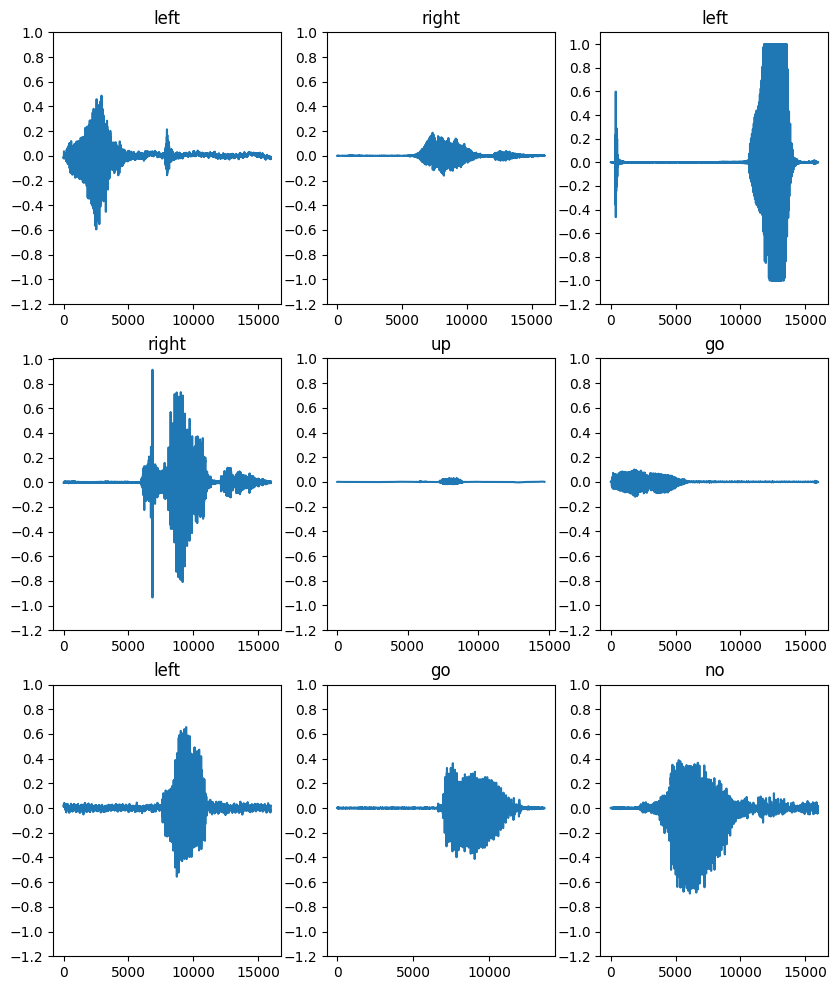

In [11]:

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [53]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [48]:
get_spectrogram(audio)

<tf.Tensor: shape=(124, 129), dtype=float32, numpy=
array([[8.5724337e-04, 7.5247530e-03, 1.2351701e-02, ..., 9.6002113e-05,
        8.3893457e-05, 1.3136101e-04],
       [4.7582835e-03, 1.8291807e-02, 1.5944466e-02, ..., 5.7749865e-05,
        1.9448235e-04, 2.4219975e-04],
       [7.4962038e-04, 6.2067974e-03, 7.5501716e-03, ..., 4.3089225e-05,
        8.1803184e-05, 1.2551667e-05],
       ...,
       [1.6114131e-01, 1.2466958e+00, 1.4350479e+00, ..., 3.3613219e-04,
        5.6111813e-04, 9.2098862e-04],
       [1.1900568e-01, 1.1587038e+00, 1.6429675e+00, ..., 5.4550206e-04,
        3.2077427e-04, 1.2655929e-04],
       [3.3825086e-03, 1.1798389e+00, 1.9313335e+00, ..., 3.7597865e-04,
        8.0624690e-05, 2.6089419e-04]], dtype=float32)>

In [52]:
get_spectrogram(audio)

<tf.Tensor: shape=(124, 129, 1), dtype=float32, numpy=
array([[[8.5724337e-04],
        [7.5247530e-03],
        [1.2351701e-02],
        ...,
        [9.6002113e-05],
        [8.3893457e-05],
        [1.3136101e-04]],

       [[4.7582835e-03],
        [1.8291807e-02],
        [1.5944466e-02],
        ...,
        [5.7749865e-05],
        [1.9448235e-04],
        [2.4219975e-04]],

       [[7.4962038e-04],
        [6.2067974e-03],
        [7.5501716e-03],
        ...,
        [4.3089225e-05],
        [8.1803184e-05],
        [1.2551667e-05]],

       ...,

       [[1.6114131e-01],
        [1.2466958e+00],
        [1.4350479e+00],
        ...,
        [3.3613219e-04],
        [5.6111813e-04],
        [9.2098862e-04]],

       [[1.1900568e-01],
        [1.1587038e+00],
        [1.6429675e+00],
        ...,
        [5.4550206e-04],
        [3.2077427e-04],
        [1.2655929e-04]],

       [[3.3825086e-03],
        [1.1798389e+00],
        [1.9313335e+00],
        ...,
        [3.7597865e

In [54]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [55]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

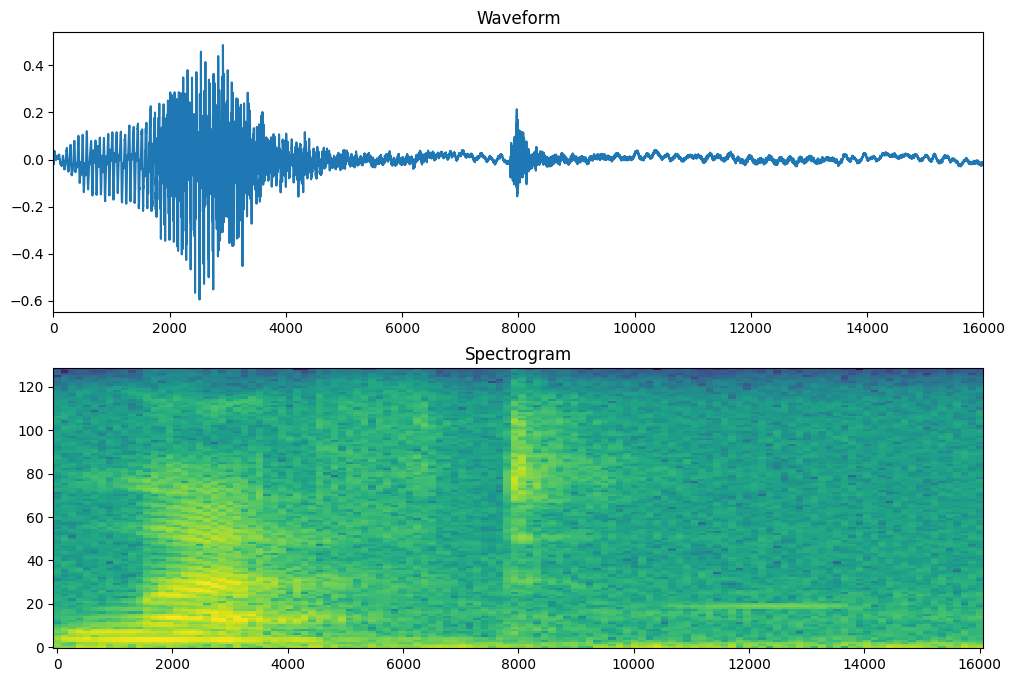

In [56]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [57]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [58]:
spectrogram_ds = waveform_ds.map(
                    map_func=get_spectrogram_and_label_id,
                    num_parallel_calls=AUTOTUNE)

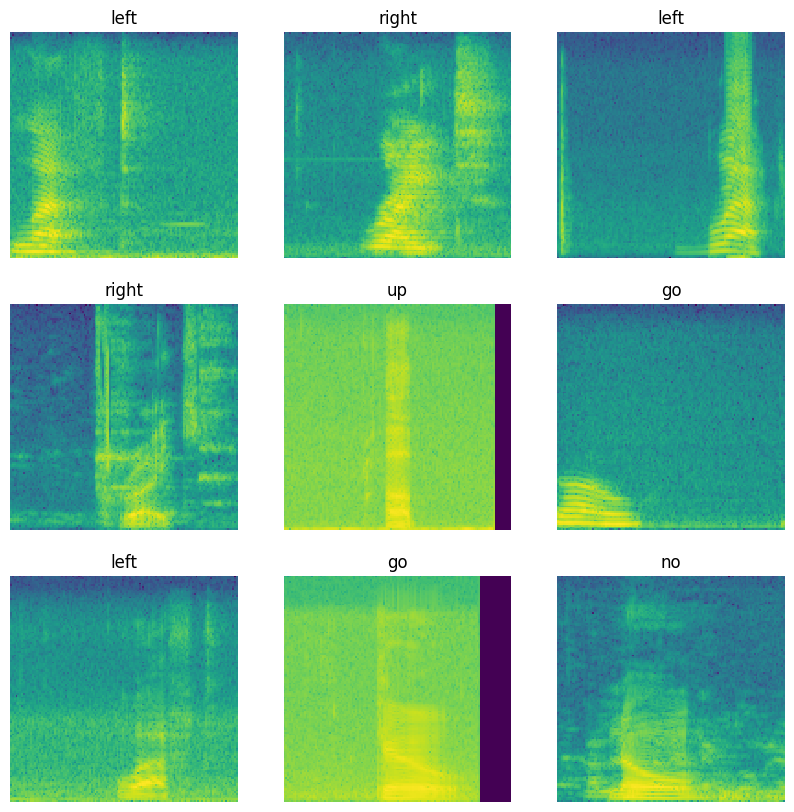

In [59]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

# Construindo modelo

In [60]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
          map_func=get_waveform_and_label,
          num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
          map_func=get_spectrogram_and_label_id,
          num_parallel_calls=AUTOTUNE)
    return output_ds

In [61]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [62]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [63]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [64]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [65]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [66]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [67]:
input_shape

TensorShape([124, 129])

In [143]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(24, 24),
    # Normalize.
    norm_layer,
    keras.layers.Conv2D(16, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=keras.regularizers.l2(0.001),
           name='conv_layer1'),
    keras.layers.MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    
    keras.layers.Conv2D(16, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=keras.regularizers.l2(0.001),
           name='conv_layer2'),
    keras.layers.MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
    
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 24, 24, 1)         0         
                                                                 
 normalization_12 (Normaliza  (None, 24, 24, 1)        3         
 tion)                                                           
                                                                 
 conv_layer1 (Conv2D)        (None, 24, 24, 16)        160       
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 12, 12, 16)       0         
                                                                 
 conv_layer2 (Conv2D)        (None, 12, 12, 16)        2320      
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 6, 6, 16)         0         
                          

In [144]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [145]:
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/25
100/100 [==============================] - 1s 5ms/step - loss: 2.0213 - accuracy: 0.2252 - val_loss: 1.7870 - val_accuracy: 0.4462
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 1.7342 - accuracy: 0.3833 - val_loss: 1.4970 - val_accuracy: 0.5175
Epoch 3/25
100/100 [==============================] - 0s 4ms/step - loss: 1.5011 - accuracy: 0.4706 - val_loss: 1.3151 - val_accuracy: 0.5537
Epoch 4/25
100/100 [==============================] - 0s 4ms/step - loss: 1.3345 - accuracy: 0.5337 - val_loss: 1.1685 - val_accuracy: 0.6125
Epoch 5/25
100/100 [==============================] - 0s 4ms/step - loss: 1.2171 - accuracy: 0.5833 - val_loss: 1.0753 - val_accuracy: 0.6637
Epoch 6/25
100/100 [==============================] - 0s 4ms/step - loss: 1.1376 - accuracy: 0.6167 - val_loss: 1.0108 - val_accuracy: 0.6812
Epoch 7/25
100/100 [==============================] - 0s 4ms/step - loss: 1.0577 - accuracy: 0.6406 - val_loss: 0.9502 - val_accuracy: 0.7212
Epoch 

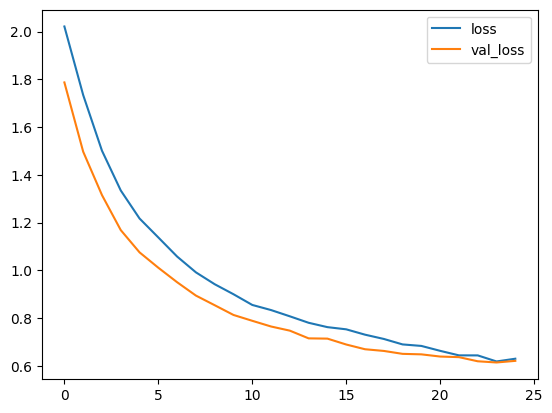

In [146]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [147]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [148]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 0s 2ms/step
Test set accuracy: 82%


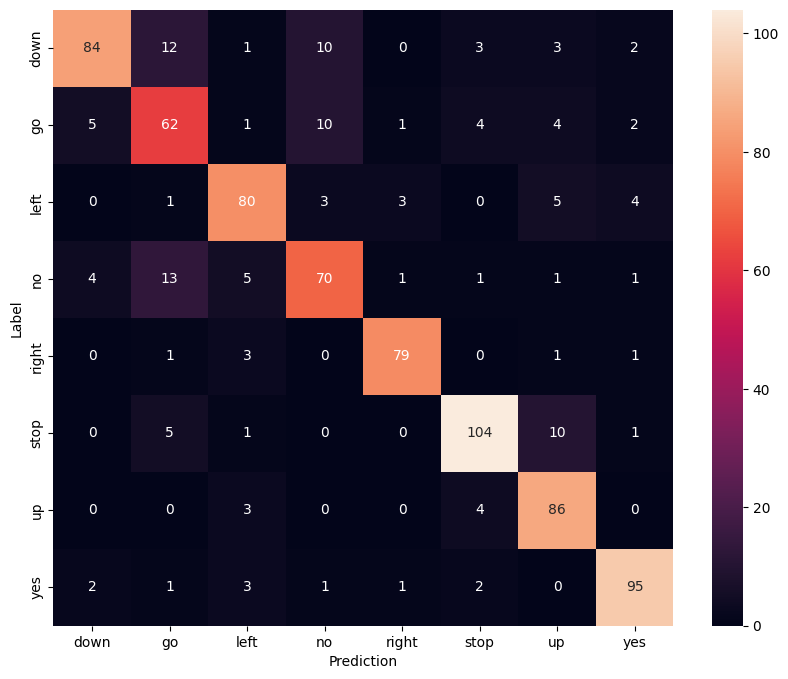

In [149]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

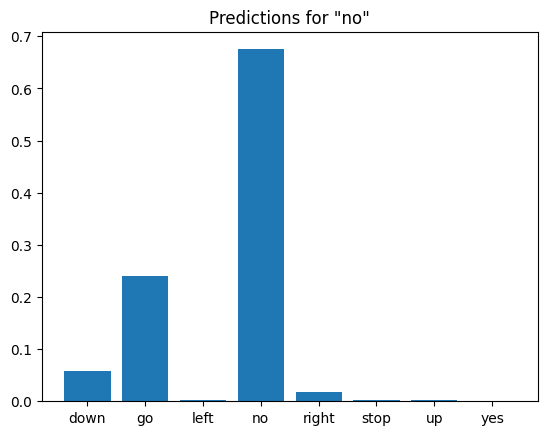

In [150]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

# Save model

In [151]:
path_saved_model = os.path.join("Saved Models", "My_Audio_Model")

In [152]:
model.save(path_saved_model)

INFO:tensorflow:Assets written to: Saved Models\My_Audio_Model\assets


INFO:tensorflow:Assets written to: Saved Models\My_Audio_Model\assets


# Loaded model

In [153]:
loaded_model = keras.models.load_model(path_saved_model)

In [154]:
loaded_model

# Tensorflow Lite

In [155]:
path_lite = os.path.join("Saved Models Lite", "AudioLite")

In [156]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(path_saved_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('modellite.tflite', 'wb') as f:
    f.write(tflite_model)